# Imports

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from dtaidistance import dtw # For DTW calculation
# from scipy.sparse import coo_matrix
import igraph as ig
import leidenalg
import matplotlib.pyplot as plt

# Load Embeddings Data

In [2]:
SYMBOL = 'BTCUSDT'
window_size = 20
stride = 5 

embeddings_df = pd.read_csv(f'data/embeddings/embed_vae_dtw_shape_{SYMBOL}_ws{window_size}_ld{stride}.csv')
embeddings_df

,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5
0,-0.010022,0.748306,-0.009012,-0.024052,0.000409
1,-0.010011,0.747651,-0.009005,-0.024004,0.000415
2,-0.009993,0.746609,-0.008992,-0.023927,0.000425
3,-0.009983,0.745863,-0.008985,-0.023875,0.000428
4,-0.009980,0.745595,-0.008984,-0.023857,0.000428
...,...,...,...,...,...
759784,0.011845,-0.683285,0.011099,0.022910,-0.000127
759785,0.011841,-0.683159,0.011097,0.022906,-0.000117
759786,0.011845,-0.682448,0.011072,0.022875,-0.000137
759787,0.011846,-0.681944,0.011056,0.022859,-0.000146


In [3]:
embeddings = embeddings_df.values.astype(np.float32)
embeddings

array([[-1.00217685e-02,  7.48305857e-01, -9.01220646e-03,
        -2.40518525e-02,  4.09349916e-04],
       [-1.00111999e-02,  7.47651339e-01, -9.00496915e-03,
        -2.40043104e-02,  4.14570910e-04],
       [-9.99309868e-03,  7.46608555e-01, -8.99225194e-03,
        -2.39274278e-02,  4.24560276e-04],
       ...,
       [ 1.18449330e-02, -6.82447553e-01,  1.10718803e-02,
         2.28745136e-02, -1.37303257e-04],
       [ 1.18460469e-02, -6.81943834e-01,  1.10562211e-02,
         2.28586700e-02, -1.46100647e-04],
       [ 1.18385591e-02, -6.81326926e-01,  1.10458918e-02,
         2.28612144e-02, -1.36219780e-04]],
      shape=(759789, 5), dtype=float32)

# k-NN Similarity Graph for Local Adjacency

In [4]:
k = 50
nbrs = NearestNeighbors(n_neighbors=k, n_jobs=-1).fit(embeddings)
neigh_dist, neigh_ind = nbrs.kneighbors(embeddings)  

In [5]:
# build directed edge lists
rows = np.repeat(np.arange(len(embeddings)), k)
cols = neigh_ind.flatten()

# compute bandwidth
sigma = np.mean(neigh_dist[:, -1])

# compute weights
diffs = embeddings[rows] - embeddings[cols]          # shape (N*k, dim)
sqd = np.sum(diffs * diffs, axis=1)                  # squared distances
edge_weights = np.exp(-sqd / (2 * sigma**2))         # shape (N*k,)

# symmetrize to make the graph undirected
rows_sym = np.concatenate([rows, cols])
cols_sym = np.concatenate([cols, rows])
weights_sym = np.concatenate([edge_weights, edge_weights])

# W = coo_matrix((weights_sym, (rows_sym, cols_sym)), shape=(len(embeddings), len(embeddings)))

# Leiden Community Detection

In [6]:
# Build a graph from sparse representation
g = ig.Graph(
    n=len(embeddings),
    edges=list(zip(rows_sym.tolist(), cols_sym.tolist())),
    directed=False
)

In [7]:
g.es['weight'] = weights_sym.tolist()

In [8]:
# Leiden
partition = leidenalg.find_partition(
    g,
    leidenalg.RBConfigurationVertexPartition,
    weights='weight',
    resolution_parameter=1.0
)
labels = np.array(partition.membership) 

In [9]:
pd.Series(labels).to_csv(
    f'data/communities/labels_{SYMBOL}_ws={window_size}_stride={stride}.csv',
    index=False,
    header=False
)
labels

array([181, 278, 278, ...,  69,  69,  69], shape=(759789,))

# Inspect and Filter Communities

In [10]:
unique, counts = np.unique(labels, return_counts=True)
print("Found", unique.size, "communities.")

Found 6761 communities.


In [11]:
unique

array([   0,    1,    2, ..., 6758, 6759, 6760], shape=(6761,))

In [12]:
counts, sum(counts) == len(embeddings)

(array([3439, 3370, 3268, ...,    1,    1,    1], shape=(6761,)), np.True_)

In [13]:
print(f"Number of values equal to 1: {len(counts[counts == 1])}")

Number of values equal to 1: 6035


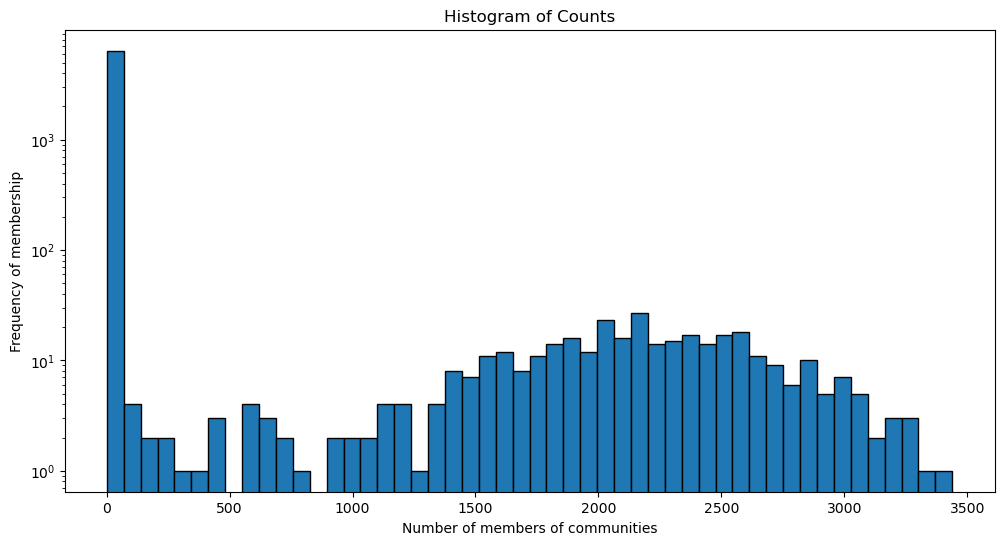

In [14]:
plt.figure(figsize=(12, 6))

plt.hist(counts, bins=50, edgecolor='black')
plt.title('Histogram of Counts')
plt.xlabel('Number of members of communities')
plt.ylabel('Frequency of membership')
plt.yscale('log')

In [15]:
# what if I analyze a text and see the distribution of its words?
# Make sure about the k-NN (i.e. how the words are similar)

In [16]:
# drop tiny noise‐like groups
min_size = 100
keep = unique[counts >= min_size]
mask = np.isin(labels, keep)
filtered_labels = np.where(mask, labels, -1)  # −1 = “noise”

In [17]:
keep.size, mask.size, filtered_labels.size

(363, 759789, 759789)

In [18]:
pd.Series(keep).to_csv(
    f'data/communities/keep_{SYMBOL}_ws={window_size}_stride={stride}.csv',
    index=False,
    header=False
)

# Compute motif centroids

In [19]:
K = keep.size
centroids = np.zeros((K, embeddings.shape[1]))
for new_id, old_id in enumerate(keep):
    centroids[new_id] = embeddings[filtered_labels == old_id].mean(axis=0)
# remap labels from old_id to new_id 
label_map = {old_id: new_id for new_id, old_id in enumerate(keep)}
node_labels = np.array([label_map[l] if l in label_map else -1
                        for l in filtered_labels])

In [20]:
pd.DataFrame(centroids).to_csv(
    f'data/communities/centroids_{SYMBOL}_ws={window_size}_stride={stride}.csv',
    index=False,
    header=False
)

In [21]:
node_labels
pd.Series(node_labels).to_csv(
    f'data/communities/node_labels_{SYMBOL}_ws={window_size}_stride={stride}.csv',
    index=False,
    header=False
)